In [236]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from scipy.stats import spearmanr, pearsonr


In [237]:
#get datasets
household_data = pd.read_csv("NHST_Data\hhpub.csv")
person_data = pd.read_csv("NHST_Data\perpub.csv")
trip_data = pd.read_csv("NHST_Data\\trippub.csv")
vehicle_data = pd.read_csv("NHST_Data\\vehpub.csv")
gas_data = pd.read_csv("data_with_gas_usage.csv")

#use data with vehicles that only use gasoline 
gas_data = gas_data.loc[gas_data['VEHFUEL'] == 1]
gas_data = gas_data.loc[gas_data['GASUSGE'].notna()]

In [238]:
#set up new dataset including unique id from vehicle data
df = pd.DataFrame({'HOUSEID' : pd.unique(gas_data['HOUSEID']),
                   'ANNMILES' : 0, 'GASUSGE' : 0,
                   'HighestEDUC' : 0,
                   'TAXISERVICE' : 0, 'RIDESHARE22' : 0, 'ESCOOTERUSED' : 0,
                   'PTUSED' : 0, 'MCTRANSIT' : 0, 'WALKTRANSIT' : 0, 
                   'BIKETRANSIT' : 0, 'EMPLOYMENT2' : 0,
                  })

person_col = ['TAXISERVICE', 'RIDESHARE22', 'ESCOOTERUSED', 'PTUSED', 'MCTRANSIT', 'WALKTRANSIT', 'BIKETRANSIT', 'EMPLOYMENT2']

#add empty columns from household data
for col_name in household_data.columns:
    if col_name != 'HOUSEID':
        df[col_name] = 0
        
for i in df.index:
    #get total gasuage of each household
    id = gas_data.loc[gas_data['HOUSEID'] == df['HOUSEID'][i]].index
    if(not id.empty):
        df.loc[i, 'ANNMILES'] = gas_data['ANNMILES'][id].sum()
        df.loc[i, 'GASUSGE'] = gas_data['GASUSGE'][id].sum()
    
    #get all column values from household data
    id = household_data.loc[household_data['HOUSEID'] == df['HOUSEID'][i]].index[0]
    for col_name in household_data.columns:
        if col_name != 'HOUSEID':
            df.loc[i, col_name] = household_data[col_name][id]
    
         
    id = person_data.loc[person_data['HOUSEID'] == df['HOUSEID'][i]].index
    df.loc[i, 'HighestEDUC'] = max(df.loc[i, 'HighestEDUC'], person_data['EDUC'][id].max())  #get highest education level of each household
    
    for col in person_col:
        #get the number of days where certain alternative travel methods are used by the household in a month
        df.loc[i, col] = max(0, person_data.iloc[id].loc[person_data[col] >= 0][col].sum())

#get ratio of child to adult and teen to adult
df['CHILD/ADULT'] = df['YOUNGCHILD']/df['NUMADLT'] 
df['TEEN/ADULT'] = df['PPT517']/df['NUMADLT']

#caterogerize whether a household is a superuser by gasuge 
df['SuperUser'] = 0
df.loc[df[df['GASUSGE'] >= df.GASUSGE.quantile(0.9)].index, 'SuperUser'] = 1


df_super = df.loc[df['SuperUser'] == 1] #dataset containing only super users
df_nonsuper = df.loc[df['SuperUser'] == 0] #dataset containing only non-super users

C:\Users\Jianwei\AppData\Local\Temp\ipykernel_17316\2656857812.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '408.25815788742875' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i, 'GASUSGE'] = gas_data['GASUSGE'][id].sum()
C:\Users\Jianwei\AppData\Local\Temp\ipykernel_17316\2656857812.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4683.5625987' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i, col_name] = household_data[col_name][id]
C:\Users\Jianwei\AppData\Local\Temp\ipykernel_17316\2656857812.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '14269.464209' has dtype incompatible with int64, please explicitly cast to a compatible

In [239]:
num_col = person_col + ["GASUSGE", "WTHHFIN", "WTHHFIN5D",
                        "WTHHFIN2D", "NUMADLT", 'DRVRCNT',
                        'CNTTDHH', 'HHSIZE', 'HHVEHCNT',
                        'PPT517', 'YOUNGCHILD', 'RESP_CNT',
                        'WRKCOUNT',
                        ]

In [240]:
#list(set(df.columns) - set(num_col))

In [241]:
df.loc[df[df['URBANSIZE']==6].index, 'URBANSIZE'] = 0
df.loc[df[df['URBRUR']==2].index, 'URBANSIZE'] = 0
df.loc[df[df['MSASIZE']==6].index, 'MSASIZE'] = 0
df.loc[df[df['HH_HISP']==2].index, 'HH_HISP'] = 0
df.loc[df[df['RAIL']==2].index, 'RAIL'] = 0
df = df.drop(columns=['URBRUR_2010','STRATUMID','TDAYDATE','FLAG100','MSACAT','CDIVMSAR'])

In [242]:
df = pd.get_dummies(df, prefix=['HOMEOWN'], columns=['HOMEOWN'])
df = pd.get_dummies(df, prefix=['CENSUS_R'], columns=['CENSUS_R'])
df = pd.get_dummies(df, prefix=['URBAN'], columns=['URBAN'])
df = pd.get_dummies(df, prefix=['HH_RACE'], columns=['HH_RACE'])
df = pd.get_dummies(df, prefix=['CENSUS_D'], columns=['CENSUS_D'])
df = pd.get_dummies(df, prefix=['HOMETYPE'], columns=['HOMETYPE'])

In [243]:

df = df.rename({'HOMEOWN_1' : 'OwnWLoan', 'HOMEOWN_2' : 'Own',
             'HOMEOWN_3' : 'Rent', 'HOMEOWN_4' : 'OccupiedWORent',
             'CENSUS_R_1': 'Region_Northeast', 'CENSUS_R_2': 'Region_Midwest',
             'CENSUS_R_3': 'Region_South', 'CENSUS_R_4': 'Region_West',
             'URBAN_1': 'Urbanarea', 'URBAN_2': 'Urbancluster',
             'URBAN_3': 'Surburban', 'URBAN_4': 'Rural',
             'HH_RACE_1' : 'White', 'HH_RACE_2' : 'Black',
             'HH_RACE_3' : 'Asian', 'HH_RACE_4' : 'Native',
             'HH_RACE_5' : 'PacificIslander', 'HH_RACE_6' : 'MultipleRace',
             'HH_RACE_97' : 'Other',
             'CENSUS_D_1' : "NewEngland", "CENSUS_D_2" : "MidAtlantic",
             'CENSUS_D_3' : "ENCentral", "CENSUS_D_4" : "WNCentral",
             'CENSUS_D_5' : "SAtlantic", "CENSUS_D_6" : "ESCentral",
             'CENSUS_D_7' : "WSCentral", "CENSUS_D_8" : "Mountain",
             'CENSUS_D_9' : "Pacific",
             'HOMETYPE_1' : 'OneFamDetached', 'HOMETYPE_2' : 'OneFamAttached',
             'HOMETYPE_3' : 'Apartment', 'HOMETYPE_4' : 'MobileHome',
             'HOMETYPE_5' : 'VehicleHome', 
    }, axis=1)

In [244]:
df.replace({False: 0, True: 1}, inplace=True)
df

C:\Users\Jianwei\AppData\Local\Temp\ipykernel_17316\1548169642.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({False: 0, True: 1}, inplace=True)


,HOUSEID,ANNMILES,GASUSGE,HighestEDUC,TAXISERVICE,RIDESHARE22,ESCOOTERUSED,PTUSED,MCTRANSIT,WALKTRANSIT,...,SAtlantic,ESCentral,WSCentral,Mountain,Pacific,OneFamDetached,OneFamAttached,Apartment,MobileHome,VehicleHome
0,9000013002,12000,408.258158,7,0,0,0,0,0,13,...,0,0,0,0,0,1,0,0,0,0
1,9000013016,10000,356.835885,6,0,0,0,0,0,7,...,0,0,0,0,0,0,0,1,0,0
2,9000013039,5000,171.387563,6,0,0,0,0,0,8,...,0,0,0,0,0,0,0,1,0,0
3,9000013041,5000,173.118751,6,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,9000013042,70020,2414.157750,8,0,3,0,8,0,9,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7161,9000218006,11000,374.625041,7,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
7162,9000218013,3000,102.395445,7,0,0,0,0,0,3,...,0,1,0,0,0,1,0,0,0,0
7163,9000218021,12100,421.380431,6,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
7164,9000218034,10000,482.619553,2,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0


In [245]:
for col in df.columns:
    print(df[col].value_counts())

HOUSEID
9000013002    1
9000147201    1
9000147369    1
9000147364    1
9000147360    1
             ..
9000076463    1
9000076440    1
9000076437    1
9000076436    1
9000218040    1
Name: count, Length: 7166, dtype: int64
ANNMILES
10000     378
12000     256
5000      242
15000     221
20000     216
         ... 
197000      1
25150       1
69300       1
67543       1
125822      1
Name: count, Length: 1362, dtype: int64
GASUSGE
344.765807     20
335.953902     15
169.673688     14
351.765950     14
0.000000       13
               ..
91.548879       1
881.852746      1
1636.181768     1
392.785804      1
736.301892      1
Name: count, Length: 5926, dtype: int64
HighestEDUC
6    2179
7    1589
4    1064
5     938
8     659
3     649
2      58
1      30
Name: count, dtype: int64
TAXISERVICE
0     6870
1       94
2       78
4       43
3       27
6       11
5        9
8        7
7        7
10       6
12       4
11       3
9        2
15       2
16       1
30       1
13       1
Name: coun

In [246]:
df.columns

Index(['HOUSEID', 'ANNMILES', 'GASUSGE', 'HighestEDUC', 'TAXISERVICE',
       'RIDESHARE22', 'ESCOOTERUSED', 'PTUSED', 'MCTRANSIT', 'WALKTRANSIT',
       'BIKETRANSIT', 'EMPLOYMENT2', 'WTHHFIN', 'WTHHFIN5D', 'WTHHFIN2D',
       'NUMADLT', 'RAIL', 'HH_HISP', 'DRVRCNT', 'CNTTDHH', 'HHFAMINC',
       'HHFAMINC_IMP', 'HHSIZE', 'HHVEHCNT', 'HHRELATD', 'LIF_CYC', 'MSASIZE',
       'TRAVDAY', 'URBANSIZE', 'URBRUR', 'PPT517', 'YOUNGCHILD', 'RESP_CNT',
       'WRKCOUNT', 'CHILD/ADULT', 'TEEN/ADULT', 'SuperUser', 'OwnWLoan', 'Own',
       'Rent', 'OccupiedWORent', 'Region_Northeast', 'Region_Midwest',
       'Region_South', 'Region_West', 'Urbanarea', 'Urbancluster', 'Surburban',
       'Rural', 'White', 'Black', 'Asian', 'Native', 'PacificIslander',
       'MultipleRace', 'Other', 'NewEngland', 'MidAtlantic', 'ENCentral',
       'WNCentral', 'SAtlantic', 'ESCentral', 'WSCentral', 'Mountain',
       'Pacific', 'OneFamDetached', 'OneFamAttached', 'Apartment',
       'MobileHome', 'VehicleHome'],


In [247]:
print('Super user average travel data')
print(df_super['ANNMILES'].values.mean(), 'ANNMILES')
print(df_super['GASUSGE'].values.mean(), 'GASUSGE\n')

print('Non superuser average travel data')
print(df_nonsuper['ANNMILES'].values.mean(), 'ANNMILES')
print(df_nonsuper['GASUSGE'].values.mean(), 'GASUSGE\n')

print('Ratio of miles used by super users vs all users: ', end='')
print(df_super['ANNMILES'].values.sum()/df['ANNMILES'].values.sum())

print('Ratio of gasoline used by super users vs all users: ', end='')
print(df_super['GASUSGE'].values.sum()/df['GASUSGE'].values.sum())


Super user average travel data
125116.35285913528 ANNMILES
5092.850155014935 GASUSGE

Non superuser average travel data
13035.202046828967 ANNMILES
499.0952099144215 GASUSGE

Ratio of miles used by super users vs all users: 0.5162408000444582
Ratio of gasoline used by super users vs all users: 0.5315060785738425


In [248]:
#search for difference of columns between two dataset
#list(set(person_data.columns) - set(household_data.columns))

In [249]:
#df.isna().sum()


In [250]:
#print(household_data.columns)
#print(person_data.columns)
#print(trip_data.columns)
#print(vehicle_data.columns)


In [259]:
s_corrlation = {}
s_pValues = {}
p_corrlation = {}

for column in df.columns:
    corr_s, pval_s = spearmanr(df['SuperUser'],df[column], nan_policy='omit')
    corr_p = pearsonr(df['SuperUser'],df[column])
    s_corrlation[column] = corr_s
    s_pValues[column] = pval_s
    p_corrlation[column] = corr_p

sorted_items = sorted(s_corrlation.items(), key=lambda item: item[1])
for key, value in sorted_items:
    if(value > 0.5):
        break
    print(key, value, s_pValues[key])
    

#sorted(p_corrlation.items(), key=lambda item: item[1], reverse=True)

Own -0.0729021411131186 6.472402492599736e-10
HighestEDUC -0.05832270453738395 7.792599163888958e-07
LIF_CYC -0.05603701430070267 2.069049904931389e-06
MSASIZE -0.05054249391886234 1.8645361875087464e-05
URBANSIZE -0.0496016611560128 2.6603879515042575e-05
HHRELATD -0.04822165340980353 4.431775551920439e-05
Urbanarea -0.046127601610167546 9.375802036929113e-05
Region_West -0.04282194378954259 0.000287841087881491
RAIL -0.042297483748961695 0.00034155592010376277
Pacific -0.04167851783600816 0.0004169796733182544
WALKTRANSIT -0.03306153238757913 0.005125965674325533
White -0.027816329014824486 0.01853471701773172
PTUSED -0.02631749713822851 0.025891719537064272
OneFamAttached -0.022423183306427105 0.05768555003583243
NewEngland -0.0173656117661603 0.14159096914609912
Region_Northeast -0.01619805309528496 0.17035873142743213
TRAVDAY -0.014506606697585227 0.21949690669652844
Mountain -0.012085394756232323 0.306348275213415
MultipleRace -0.011841769964904436 0.3162023449570328
HHFAMINC -0.

Text(0.5, 1.0, 'Household driver count')

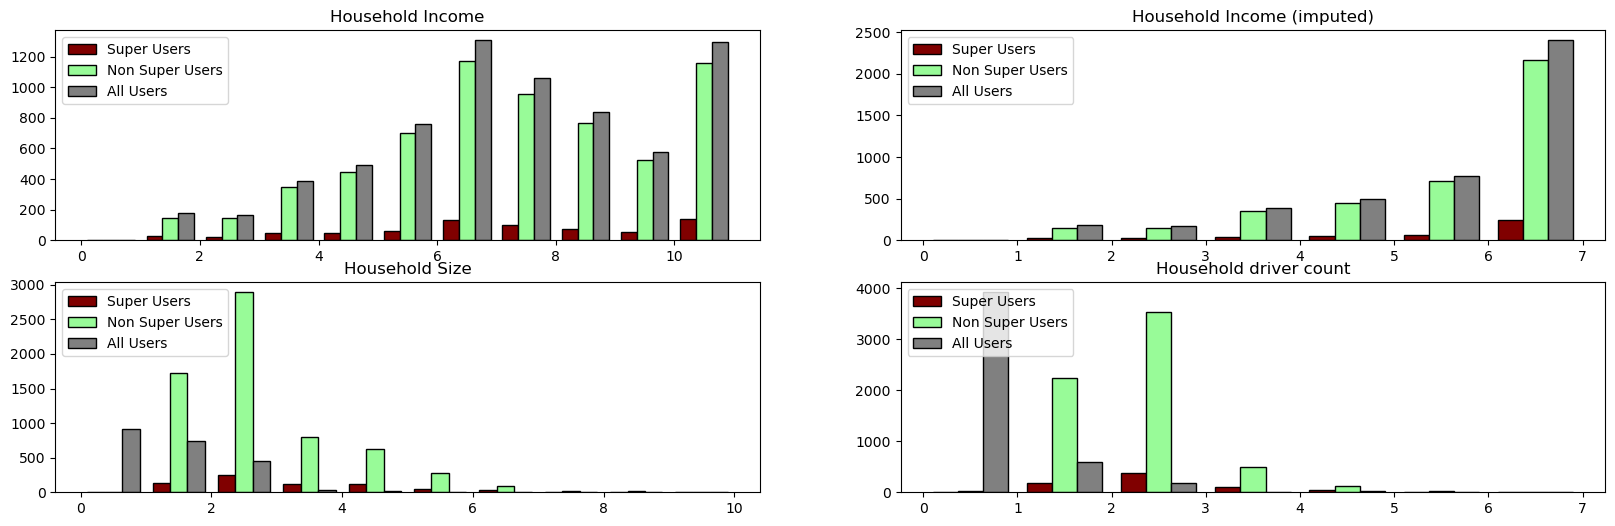

In [260]:
color = ['maroon', 'palegreen', 'gray']
label = ['Super Users', 'Non Super Users', 'All Users']

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows = 2, ncols = 2, figsize=(20,6))
ax0.hist([df_super['HHFAMINC'], df_nonsuper['HHFAMINC'], df['HHFAMINC']], bins= np.arange(0,12), color=color, edgecolor = 'black', label=label)
#ax0.hist(df_super['HHFAMINC'], bins= np.arange(0,12), color=color[0], edgecolor = 'black', label=label[0])
ax0.legend(loc=2)
ax0.set_title('Household Income')

ax1.hist([df_super['HHFAMINC_IMP'], df_nonsuper['HHFAMINC_IMP'], df['HHFAMINC_IMP']], bins= np.arange(0,8), color=color, edgecolor = 'black', label=label)
#ax1.hist(df_super['HHFAMINC_IMP'], bins= np.arange(0,12), color=color[0], edgecolor = 'black', label=label[0])
ax1.legend(loc=2)
ax1.set_title('Household Income (imputed)')

ax2.hist([df_super['HHSIZE'], df_nonsuper['HHSIZE'], df['HHSIZE']], bins= np.arange(0,11), color=color, edgecolor = 'black', label=label)
#ax2.hist(df_super['HHSIZE'], bins= np.arange(0,12), color=color[0], edgecolor = 'black', label=label[0])
ax2.legend(loc=2)
ax2.set_title('Household Size')

ax3.hist([df_super['DRVRCNT'], df_nonsuper['DRVRCNT'], df['DRVRCNT']], bins= np.arange(0,8), color=color, edgecolor = 'black', label=label)
#ax3.hist(df_super['DRVRCNT'], bins= np.arange(0,12), color=color[0], edgecolor = 'black', label=label[0])
ax3.legend(loc=2)
ax3.set_title('Household driver count')

Text(0.5, 1.0, 'Household vehicle count')

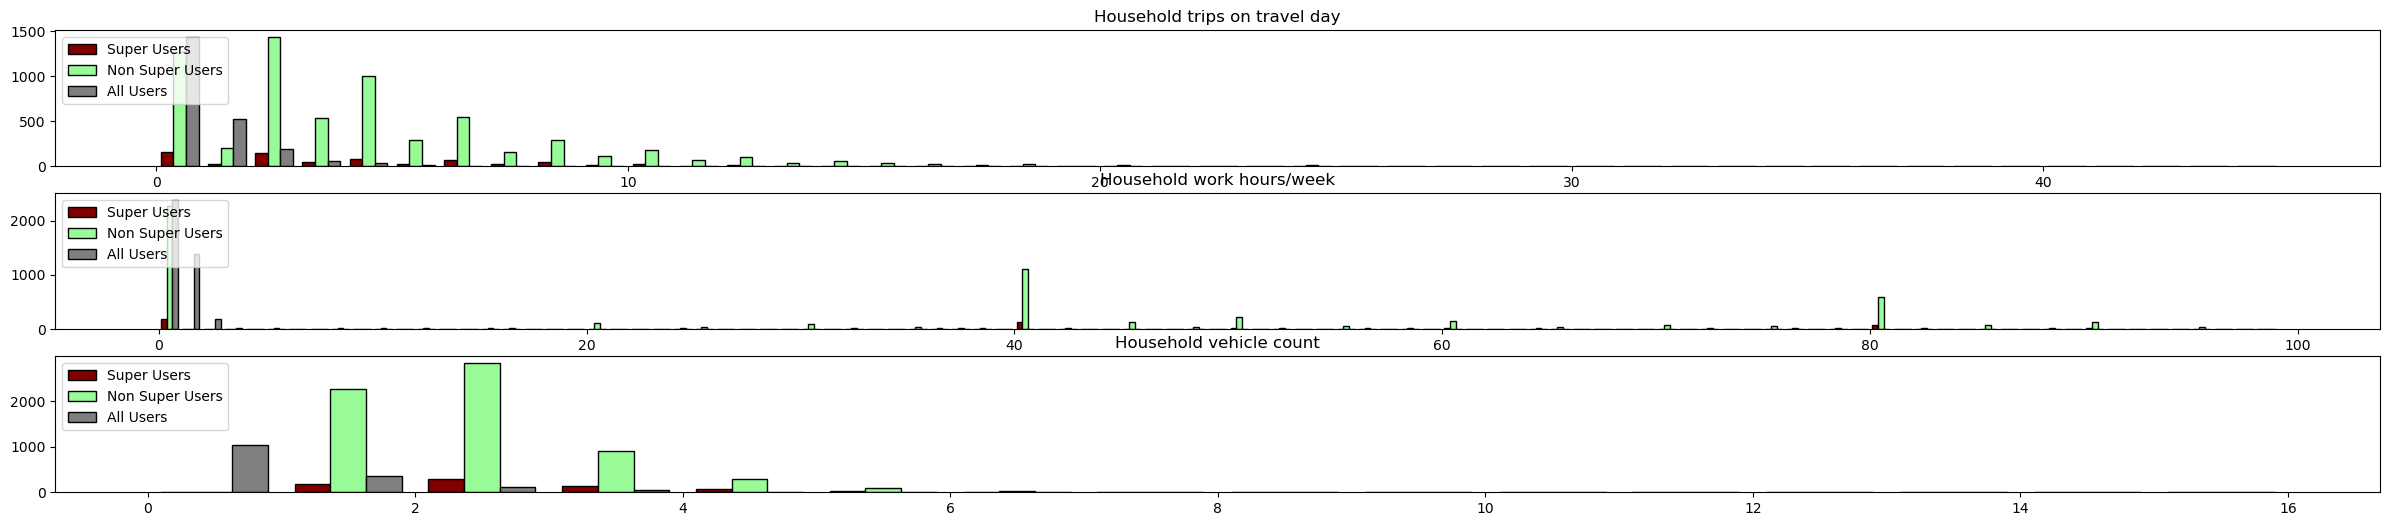

In [261]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows = 3, ncols = 1, figsize=(30,6))
ax0.hist([df_super['CNTTDHH'], df_nonsuper['CNTTDHH'], df['CNTTDHH']], bins= np.arange(0,46), color=color, edgecolor = 'black', label=label)
ax0.legend(loc=2)
ax0.set_title('Household trips on travel day')

ax1.hist([df_super['EMPLOYMENT2'], df_nonsuper['EMPLOYMENT2'], df['EMPLOYMENT2']], bins= np.arange(0,100), color=color, edgecolor = 'black', label=label)
ax1.legend(loc=2)
ax1.set_title('Household work hours/week')

ax2.hist([df_super['HHVEHCNT'], df_nonsuper['HHVEHCNT'], df['HHVEHCNT']], bins= np.arange(0,17), color=color, edgecolor = 'black', label=label)
ax2.legend(loc=2)
ax2.set_title('Household vehicle count')

In [262]:
#normalize all numeric values
num_col = person_col + ["GASUSGE", "WTHHFIN", "WTHHFIN5D",
                        "WTHHFIN2D", "NUMADLT", 'DRVRCNT',
                        'CNTTDHH', 'HHSIZE', 'HHVEHCNT',
                        'PPT517', 'YOUNGCHILD', 'RESP_CNT',
                        'WRKCOUNT',
                        ]
#"""
standard_scaler = StandardScaler()
for col in num_col:
    df[col] = standard_scaler.fit_transform(df[[col]])
#"""
"""
minmax_scaler = MinMaxScaler()
for col in num_col:
    df[col] = minmax_scaler.fit_transform(df[[col]])
"""
df

,HOUSEID,ANNMILES,GASUSGE,HighestEDUC,TAXISERVICE,RIDESHARE22,ESCOOTERUSED,PTUSED,MCTRANSIT,WALKTRANSIT,...,SAtlantic,ESCentral,WSCentral,Mountain,Pacific,OneFamDetached,OneFamAttached,Apartment,MobileHome,VehicleHome
0,9000013002,12000,-0.270053,7,-0.146325,-0.291888,-0.083774,-0.220185,-0.139403,0.460058,...,0,0,0,0,0,1,0,0,0,0
1,9000013016,10000,-0.295280,6,-0.146325,-0.291888,-0.083774,-0.220185,-0.139403,-0.013900,...,0,0,0,0,0,0,0,1,0,0
2,9000013039,5000,-0.386259,6,-0.146325,-0.291888,-0.083774,-0.220185,-0.139403,0.065093,...,0,0,0,0,0,0,0,1,0,0
3,9000013041,5000,-0.385410,6,-0.146325,-0.291888,-0.083774,-0.220185,-0.139403,-0.566852,...,0,0,0,0,0,0,1,0,0,0
4,9000013042,70020,0.714016,8,-0.146325,0.745818,-0.083774,1.567999,-0.139403,0.144086,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7161,9000218006,11000,-0.286553,7,-0.146325,-0.291888,-0.083774,-0.220185,-0.139403,-0.566852,...,0,1,0,0,0,1,0,0,0,0
7162,9000218013,3000,-0.420106,7,-0.146325,-0.291888,-0.083774,-0.220185,-0.139403,-0.329873,...,0,1,0,0,0,1,0,0,0,0
7163,9000218021,12100,-0.263616,6,-0.146325,-0.291888,-0.083774,-0.220185,-0.139403,-0.566852,...,0,1,0,0,0,1,0,0,0,0
7164,9000218034,10000,-0.233573,2,-0.146325,-0.291888,-0.083774,-0.220185,-0.139403,-0.566852,...,0,1,0,0,0,1,0,0,0,0


In [263]:
df.to_csv("processed_data.csv", index=False)
#df_super.to_csv("processed_data_superuserOnly.csv", index=False)